# Finetuned VAE for Embedding

Using a finetrained VAE for image embedding, into downstream UMAP.

*Aniket Pant, Personal*

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import os
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import umap

# Setting device for GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [4]:
device

device(type='cuda')

# Operate with model for training

In [125]:
# Prepare Dataset
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Define indices
indices = np.random.choice(np.arange(81001), size=20_000, replace=False)

# Create ImageFolder and Subset
image_datasets = datasets.ImageFolder('./wikiart', data_transform)
subset_datasets = Subset(image_datasets, indices)

# Get filenames from the ImageFolder using Subset indices
filenames = [image_datasets.imgs[i][0] for i in subset_datasets.indices]

In [126]:
dataloaders = DataLoader(subset_datasets, batch_size=32, shuffle=True, num_workers=4)

In [127]:
next(iter(dataloaders))[0].shape

torch.Size([32, 3, 256, 256])

In [128]:
dataset_sizes = len(image_datasets)
print(dataset_sizes)

81451


In [129]:
# DEFINE MODEL FOR VAE
from vae import VAE, ConvVAE

latent_dim = 64

# model = VAE(latent_dim=latent_dim).to(device)
model = ConvVAE(latent_dim=latent_dim).to(device)

In [130]:
# model(next(iter(dataloaders))[0].cuda())

In [131]:
def train_vae(vae, dataloader, optimizer, num_epochs):
    loss_history = []
    for epoch in range(num_epochs):
        for i, (inputs, _) in enumerate(dataloader):
            inputs = inputs.to(device)
            # Forward pass
            recon_batch, mu, logvar = vae(inputs)
            # Compute loss
            BCE = F.binary_cross_entropy(recon_batch, inputs, reduction='sum')
            KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = BCE + 10 * KLD
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            
            if i % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                      .format(epoch+1, num_epochs, i+1, len(dataloader), loss.item()))

    return loss_history

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Assume dataloaders is your dataloader
loss_hist = train_vae(model, dataloaders, optimizer, num_epochs=20)

Epoch [1/20], Step [1/625], Loss: 4354287.5000
Epoch [1/20], Step [101/625], Loss: 3869630.7500
Epoch [1/20], Step [201/625], Loss: 3682830.0000
Epoch [1/20], Step [301/625], Loss: 3591349.2500
Epoch [1/20], Step [401/625], Loss: 3709867.0000
Epoch [1/20], Step [501/625], Loss: 3625110.0000
Epoch [1/20], Step [601/625], Loss: 3691197.5000
Epoch [2/20], Step [1/625], Loss: 3671275.0000
Epoch [2/20], Step [101/625], Loss: 3785326.5000
Epoch [2/20], Step [201/625], Loss: 3615731.0000
Epoch [2/20], Step [301/625], Loss: 3583142.2500
Epoch [2/20], Step [401/625], Loss: 3588448.2500
Epoch [2/20], Step [501/625], Loss: 3594285.5000
Epoch [2/20], Step [601/625], Loss: 3566065.7500
Epoch [3/20], Step [1/625], Loss: 3578040.7500
Epoch [3/20], Step [101/625], Loss: 3616365.0000
Epoch [3/20], Step [201/625], Loss: 3563648.5000
Epoch [3/20], Step [301/625], Loss: 3643186.0000
Epoch [3/20], Step [401/625], Loss: 3534945.7500
Epoch [3/20], Step [501/625], Loss: 3598984.2500
Epoch [3/20], Step [601/62

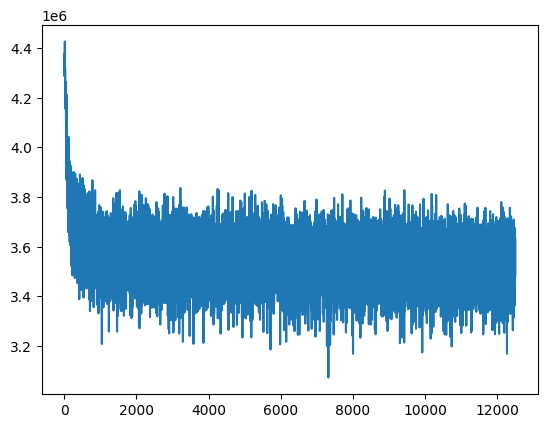

In [132]:
plt.plot(loss_hist)

## Get embeddings

In [133]:
def extract_vae_features(vae, loader):
    features = []
    labels = []

    with torch.no_grad():
        for i, (inputs, classes) in tqdm(enumerate(loader)):
            inputs = inputs.to(device)
            mu, logvar = vae.encode(inputs)  # Ensure inputs are flattened
            features.extend(mu.cpu().numpy())
            labels.extend(classes.cpu().numpy())
    return features, labels

In [134]:
# Assume vae is your trained VAE model and dataloader is your DataLoader
features, labels = extract_vae_features(model, dataloaders)

625it [01:55,  5.42it/s]


In [135]:
# Use UMAP to reduce dimensionality
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(features)

In [136]:
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(6, 4))

    le = preprocessing.LabelEncoder()
    classes = le.fit_transform(labels)

    # Create a scatter plot
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c = classes, s = 1, alpha = 0.3)

    plt.colorbar()
    plt.axis("off")
    plt.show()

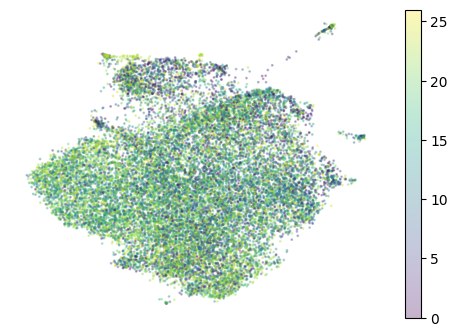

In [137]:
plot_embeddings(embedding, labels)

In [138]:
np.save("embeddings.npy", embedding)
np.save("labels.npy", labels)
np.save("filenames.npy", filenames)